## 1. Data loading

In [157]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import math

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split

In [159]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.titlesize']=12
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12


%matplotlib inline 

In [160]:
from sklearn.preprocessing import StandardScaler

In [161]:
!ls data/

sample_submission.csv test.csv              train.csv


In [162]:
BASEPATH = os.path.join('input')
TRAIN_PATH = os.path.join(BASEPATH, 'train.csv')
TEST_PATH = os.path.join(BASEPATH, 'test.csv')

In [163]:
train = pd.read_csv(TRAIN_PATH)

## 2. Data exploration

In [164]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [165]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


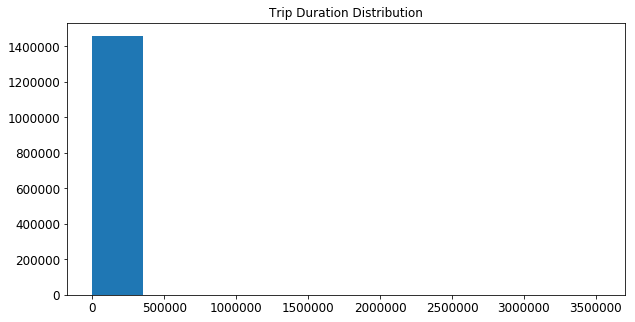

In [166]:
mpl.rcParams['figure.figsize']=(10,5)

plt.hist(train['trip_duration'])
plt.title("Trip Duration Distribution");

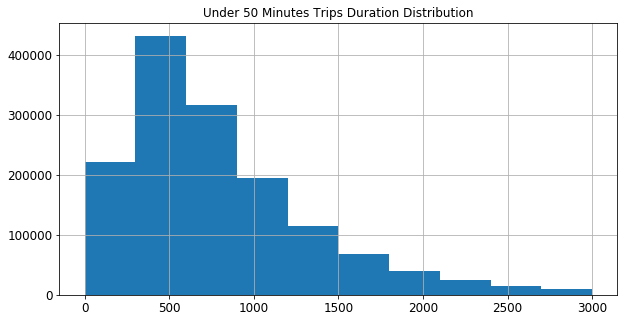

In [167]:
train.loc[train['trip_duration'] < 3000, 'trip_duration'].hist()
plt.title("Under 50 Minutes Trips Duration Distribution");

In [168]:
test = pd.read_csv(TEST_PATH)
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [169]:
train.dtypes, test.dtypes

(id                     object
 vendor_id               int64
 pickup_datetime        object
 dropoff_datetime       object
 passenger_count         int64
 pickup_longitude      float64
 pickup_latitude       float64
 dropoff_longitude     float64
 dropoff_latitude      float64
 store_and_fwd_flag     object
 trip_duration           int64
 dtype: object, id                     object
 vendor_id               int64
 pickup_datetime        object
 passenger_count         int64
 pickup_longitude      float64
 pickup_latitude       float64
 dropoff_longitude     float64
 dropoff_latitude      float64
 store_and_fwd_flag     object
 dtype: object)

In [170]:
NUM_VARS = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'pickup_latitude',
           'dropoff_longitude', 'dropoff_latitude']
CAT_VARS = ['pickup_datetime','dropoff_datetime', 'store_and_fwd_flag']

## 3. Data preprocessing

Data has been sampled and clean - there are no outliers and no missing values.

#### Outliers 

In [171]:
for feature in NUM_VARS:
    print("Variance of",feature,":",train[feature].var(),"\n")

Variance of vendor_id : 0.24877864925778634 

Variance of passenger_count : 1.7272324756558137 

Variance of pickup_longitude : 0.00502707352779222 

Variance of pickup_latitude : 0.0010811724097092013 

Variance of pickup_latitude : 0.0010811724097092013 

Variance of dropoff_longitude : 0.004990471327453372 

Variance of dropoff_latitude : 0.0012881319816812026 



#### Missing values 

No missing values in the entire dataset

In [172]:
missing_val_count = (train.isnull().sum())
missing_val_count

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### Categorical Data

In [173]:
# train
for column in CAT_VARS:
    train[column] = train[column].astype('category').cat.codes
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,551677,551464,1,-73.982155,40.767937,-73.964630,40.765602,0,455
1,id2377394,1,1242712,1242868,1,-73.980415,40.738564,-73.999481,40.731152,0,663
2,id3858529,2,132900,132995,1,-73.979027,40.763939,-74.005333,40.710087,0,2124
3,id3504673,2,730930,730736,1,-74.010040,40.719971,-74.012268,40.706718,0,429
4,id2181028,2,643836,643621,1,-73.973053,40.793209,-73.972923,40.782520,0,435


In [174]:
# test
for column in CAT_VARS:
    if(column != 'dropoff_datetime'):
        test[column] = test[column].astype('category').cat.codes
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,610580,1,-73.988129,40.732029,-73.990173,40.756680,0
1,id3505355,1,610579,1,-73.964203,40.679993,-73.959808,40.655403,0
2,id1217141,1,610578,1,-73.997437,40.737583,-73.986160,40.729523,0
3,id2150126,2,610577,1,-73.956070,40.771900,-73.986427,40.730469,0
4,id1598245,1,610576,1,-73.970215,40.761475,-73.961510,40.755890,0


## 4. Features

In [185]:
X_train = train[['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']]
X_train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,2,551677,1,-73.982155,40.767937,-73.964630,40.765602,0
1,1,1242712,1,-73.980415,40.738564,-73.999481,40.731152,0
2,2,132900,1,-73.979027,40.763939,-74.005333,40.710087,0
3,2,730930,1,-74.010040,40.719971,-74.012268,40.706718,0
4,2,643836,1,-73.973053,40.793209,-73.972923,40.782520,0


In [186]:
y_train = train['trip_duration']
y_train.head()

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

## 6. Model 

In [193]:
t_X, val_X, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

In [198]:
rf = RandomForestRegressor(random_state=1, n_jobs=-1)
rf.fit(t_X, t_y)
preds = rf.predict(val_X)
print(np.sqrt(MSLE(val_y, preds)))

0.5786890688323296


## 8. Predictions

In [199]:
test_p = test[['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']]
preds = rf.predict(test_p)
preds[:20]

array([ 993. ,  611.2,  468. , 1041.5,  402.6, 1120.2, 1097. ,  689.8,
       2159.9,  672.4, 1069.1,  412.8,  555. ,  692.6, 1389.1,  763.1,
       1222.3,  416. ,  156.4, 1056.6])

In [202]:
sub = pd.DataFrame({'id':test.id,'trip_duration':preds})
sub.head(5)

,id,trip_duration
0,id3004672,993.0
1,id3505355,611.2
2,id1217141,468.0
3,id2150126,1041.5
4,id1598245,402.6


In [203]:
sub.to_csv('submission.csv', index=0)